# Examples using RBM and Autoencoder

## RBM

The building block for pretraining our autoencoder. RBM.py defines a restricted Boltzmann machine object. In the following section we demonstrate how it works.

In [13]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt

from RBM import *
from Autoencoder import *

In [48]:
# load training data
df = pd.read_csv("train.csv")
x = df.values[:,1:]
x = x.T
x = (x > 0.35*255).astype(int)  # convert images from greyscale to black and white
x.shape

val = pd.read_csv("test.csv")
t = val.values
t = (t > 0.35*255).astype(int)  # convert images from greyscale to black and white

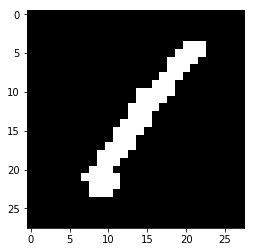

In [15]:
# here is an example of an image from MNIST
plt.imshow(x[:,0].reshape((28,28)),cmap=plt.cm.gray)
plt.show()

In [4]:
# load pre-trained RBM
rbm = RBM.from_File("./trained_weights/RBM_15_epochs/RBMweights")

In [ ]:
# reconstruct an image (easier)
v,_ = rbm.gibbs_sampling(5000,1)
plt.imshow(v.reshape((28,28)),cmap=plt.cm.gray)
plt.show()

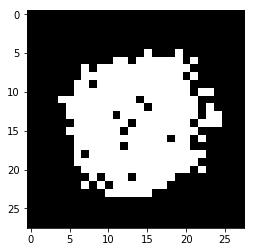

In [57]:
# randomly generate an image (harder, would benefit from more epochs of training)
# the RBM doesn't do that well, but we will see below that the generator part of 
# the autoencoder does much better
v,_ = rbm.gibbs_sampling(200,1)
plt.imshow(v.reshape((28,28)),cmap=plt.cm.gray)
plt.show()

# Autoencoder

In this section, we will demonstrate the results of the trained autoencoder.

In [62]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input
from livelossplot import PlotLossesKeras

In [63]:
# load the model, which we have pretrained and then fine-tuned 
model = load_model("trained_weights/Keras_model_40_epochs.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                7530      
_________________________________________________________________
dense_5 (Dense)              (None, 250)               7750      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               125500    
__________

## Encoder

Let's extract the trained encoder and use it to perform cluster analysis on the compressed images.

In [64]:
# extract the encoder from the autoencoder

inputs = Input(shape=(784,))
X = model.get_layer("dense_1")(inputs)
X = model.get_layer("dense_2")(X)
X = model.get_layer("dense_3")(X)
Y = model.get_layer("dense_4")(X)
            
encoder = Model(inputs,Y)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                7530      
Total params: 1,418,280
Trainable params: 1,418,280
Non-trainable params: 0
_________________________________________________________________


In [49]:
codes = encoder.predict(x.T)

## Decoder/generator

Now let's extract the generator network and generate some images from random noise.

In [65]:
# extract the decoder/generator

noise = Input(shape=(30,))
X = model.get_layer("dense_5")(noise)
X = model.get_layer("dense_6")(X)
X = model.get_layer("dense_7")(X)
Y = model.get_layer("dense_8")(X)
            
decoder = Model(noise,Y)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               7750      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               784784    
Total params: 1,419,034
Trainable params: 1,419,034
Non-trainable params: 0
_________________________________________________________________


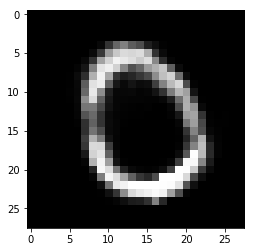

In [104]:
noise = np.random.random((1,30))
image = decoder.predict(noise)

plt.imshow(image.reshape((28,28)),cmap=plt.cm.gray)
plt.show()

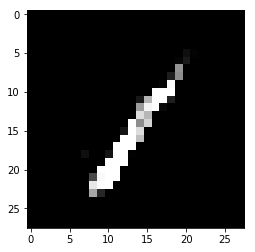

In [95]:
noise = np.random.normal(0,1,(1,30))
image = decoder.predict(noise)

plt.imshow(image.reshape((28,28)),cmap=plt.cm.gray)
plt.show()

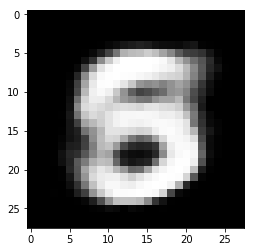

In [108]:
noise = np.random.normal(2,10,(1,30))
image = decoder.predict(noise)

plt.imshow(image.reshape((28,28)),cmap=plt.cm.gray)
plt.show()